In [21]:

#@title Importing modules
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import pandas as pd
#from emcee.autocorr import function_1d
#import emcee
import matplotlib.pyplot as plt
import gillespy2
import os
from scipy.sparse import csr_matrix # For sparse matrices
from typing import List
from scipy.sparse.linalg import expm_multiply
from tqdm.auto import tqdm
#from joblib import Parallel, delayed
import seaborn as sns
import shutil
import matplotlib.ticker as ticker
figSize=800

import pathlib
# current directory
current_dir = pathlib.Path().absolute()

# if folder_outputs doesnt exist, create it
folder_outputs = current_dir.joinpath('sim_outputs')

# Removing directory if exist
if os.path.exists(folder_outputs):
    shutil.rmtree(folder_outputs)
# Creating the directory
folder_outputs.mkdir(parents=True, exist_ok=True)


# Model

| Index | Reaction | Description | Reaction Rate |
|-------|----------|-------------|---------------|
| $r_1$ | $G_{off} \xrightarrow[]{k_{on}} G_{on}$ | gene activation | $k_{on} \cdot [G_{off}]$ |
| $r_2$ | $G_{on} \xrightarrow[]{k_{off}} G_{off}$ | gene deactivation | $k_{off} \cdot [G_{on}]$ |
| $r_3$ | $G_{on} \xrightarrow[]{k_{r}} G_{on} + R_{n}$ | active gene produces mRNA | $k_{r} \cdot [G_{on}]$ |
| $r_4$ | $R_{n} \xrightarrow[]{k_{t}} R_{c}$ | mRNA transport to cytoplasm | $k_{t} \cdot [R_{n}]$ |
| $r_5$ | $R_{c} \xrightarrow[]{k_{p}} R_{c} + P$ | mRNA in cytoplasm produces Protein | $k_{p} \cdot [R_{c}]$ |
| $r_6$ | $R_{n} \xrightarrow[]{\gamma_{r_n}} \phi$ | nuclear mRNA decay | $\gamma_{r_n} \cdot [R_{n}]$ |
| $r_7$ | $R_{c} \xrightarrow[]{\gamma_{r_c}} \phi$ | cytoplasm mRNA decay | $\gamma_{r_c} \cdot [R_{c}]$ |
| $r_8$ | $P \xrightarrow[]{\gamma_p} \phi$ | protein decay | $\gamma_p \cdot [P]$ |



In [22]:
#@title Plotting configuration
plt.rcParams.update({
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 10,
})
# Assign colors to each species for consistent plotting
species_colors = {
    'G_off': 'blue',
    'G_on': 'orange',
    'R_n': 'green',
    'R_c': 'red',
    'P': 'purple'
}

In [23]:
#@title Plotting ODE model
def plotting_deterministic(time,concentrations_species,species_colors,drug_application_time=None,ylim_val=False):
    plt.figure(figsize=(8, 5))
    for species, color in species_colors.items():
        plt.plot(time, concentrations_species[species], color=color, label=species,lw=4)
    if not drug_application_time is None:
        plt.axvline(x=drug_application_time, color='k', linestyle='--', label= r'$t_{drug}$',lw=1.5)
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.title('Deterministic Dynamics')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    if ylim_val:
        plt.ylim(0,ylim_val)
    plt.show()

In [24]:
#@title Plotting SSA model
def plotting_stochastic(time, trajectories_species,species_colors,drug_application_time=None,ylim_val=False):
    def plot_species_trajectories(time, trajectories_species, species_name, color):
        # Extract the trajectories for the species
        trajectories = trajectories_species[species_name]
        # Calculate the mean and standard deviation across all trajectories
        mean_trajectories = np.mean(trajectories, axis=0)
        std_trajectories = np.std(trajectories, axis=0)
        # Plot mean concentration with standard deviation as shaded area
        plt.plot(time, mean_trajectories, '-', color=color, label=species_name, lw=4)
        plt.fill_between(time, mean_trajectories - std_trajectories, mean_trajectories + std_trajectories, color=color, alpha=0.1)
    plt.figure(figsize=(8, 5))
    # Plot each species
    for species, color in species_colors.items():
        plot_species_trajectories(time, trajectories_species, species, color)
    # Mark the drug application time
    if not drug_application_time is None:
        plt.axvline(x=drug_application_time, color='k', linestyle='--', label=r'$t_{drug}$', lw=1.5)
    # Set plot details
    plt.xlabel('Time')
    plt.ylabel('Number of Molecules')
    plt.title('Stochastic Dynamics')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    if ylim_val:
        plt.ylim(0,ylim_val)
    plt.show()


In [25]:
def plotting_stochastic_dist(time, trajectories_species, species_name, species_color_dist, time_points, ylim_val=False):
    def plot_species_trajectories(ax, time, trajectories_species, species_name, color, time_point):
        # Extract the trajectories for the species at the specific time point
        trajectories = trajectories_species[species_name][:, time_point]
        # Plot distribution of species count at the specified time point
        ax.hist(trajectories, bins=20, color=color, alpha=0.7, label=f"{species_name} at time={time[time_point]}")
        ax.legend(loc='upper right')
    # Set up a 2x2 subplot grid
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = axs.flatten()  # Flatten the 2x2 array to easily loop over it

    # Plot the species distribution at each of the four user-selected time points
    for i, time_point in enumerate(time_points):
        plot_species_trajectories(axs[i], time, trajectories_species, species_name, species_color_dist, time_point)
        axs[i].set_xlabel('Number of Molecules')
        axs[i].set_ylabel('Frequency')
        if ylim_val:
            axs[i].set_ylim(0, ylim_val)
    # Set a general title
    plt.suptitle(f'Distribution of {species_name} at Different Time Points')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust subplots to fit into the figure area
    plt.show()

#species_name = 'G_on'  # Example species
#species_color_dist = 'blue'  # Example color for the species
#time_points = [5, 10, 20, 100]  # User-selected time points (indices from the 'time' array)


In [26]:
def plotting_stochastic_dist_all_species(time, trajectories_species, species_colors, time_point, ylim_val=False):
    n_species = len(species_colors)  # Number of species to plot
    n_cols = n_species  # Number of columns in subplot grid
    n_rows = 1
    def plot_species_trajectories(ax, time, trajectories_species, species_name, color, time_point):
        # Extract the trajectories for the species at the specific time point
        trajectories = trajectories_species[species_name][:, time_point]
        # Plot distribution of species count at the specified time point
        ax.hist(trajectories, bins=30, color=color, alpha=0.7, label=f"{species_name} ") # at time={time[time_point]}")
        ax.legend(loc='upper right')
        ax.set_xlabel('Number of Molecules')
        ax.set_ylabel('Frequency')
        if ylim_val:
            ax.set_ylim(0, ylim_val)
    # Set up subplot grid
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 3 * n_rows), squeeze=False)
    axs = axs.flatten()  # Flatten the array to easily loop over it
    # Plot the species distribution at the selected time point
    for i, (species_name, species_color) in enumerate(species_colors.items()):
        plot_species_trajectories(axs[i], time, trajectories_species, species_name, species_color, time_point)
    for ax in axs[i+1:]:  # Hide unused subplots
        ax.set_visible(False)
    # Set a general title
    plt.suptitle(f'Distribution of Species at Time={time[time_point]}',fontsize=20 )
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [27]:

def plotting_combined(time, trajectories_species, species_colors, drug_application_time=None, ylim_val=False,time_point=10):
    # Define the structure of the plot grid
    fig, axs = plt.subplots(2, 3, figsize=(18, 10), squeeze=False)

    # Function to plot time courses for all species
    def plot_time_courses(ax, time, trajectories_species, species_colors, drug_application_time):
        for species_name, color in species_colors.items():
            trajectories = trajectories_species[species_name]
            mean_trajectories = np.mean(trajectories, axis=0)
            std_trajectories = np.std(trajectories, axis=0)
            ax.plot(time, mean_trajectories, '-', color=color, label=species_name, lw=2)
            ax.fill_between(time, mean_trajectories - std_trajectories, mean_trajectories + std_trajectories, color=color, alpha=0.1)
        if drug_application_time is not None:
            ax.axvline(x=drug_application_time, color='k', linestyle='--', label='Drug application', lw=1.5)
        ax.set_xlabel('Time')
        ax.set_ylabel('Number of Molecules')
        ax.legend(loc='upper right', fontsize=14)
        ax.set_title('Time Courses for All Species')
        if ylim_val:
            ax.set_ylim(0, ylim_val)

    # Function to plot distribution of species count at a specified time point
    def plot_species_distribution(ax, time, trajectories_species, species_name, color, time_point):
        trajectories = trajectories_species[species_name][:, time_point]
        ax.hist(trajectories, bins=30, color=color, alpha=0.7, label=f"{species_name}")
        ax.legend(loc='upper right', fontsize=18)
        ax.set_xlabel('Number of Molecules')
        ax.set_ylabel('Frequency')
        if ylim_val:
            ax.set_ylim(0, ylim_val)
        ax.set_title(f'Distribution at Time={time[time_point]}')

    # Plot time courses for all species in the first subplot
    plot_time_courses(axs[0, 0], time, trajectories_species, species_colors, drug_application_time)

    # Plot the distributions for each species in the remaining subplots
    species_list = list(species_colors.keys())
    for i, species_name in enumerate(species_list[:5]):  # Adjust based on the number of species and subplot slots
        col = (i + 1) % 3
        row = (i + 1) // 3
        plot_species_distribution(axs[row, col], time, trajectories_species, species_name, species_colors[species_name], time_point)

    # Hide any unused subplots
    for j in range(i + 2, 6):
        axs.flatten()[j].set_visible(False)

    plt.tight_layout()
    plt.show()

In [28]:
#@title Creating Model in Gillespy2
class GeneExpressionModel(gillespy2.Model):
    def __init__(self, parameter_values,initial_conditions):
        super(GeneExpressionModel, self).__init__('GeneExpressionModel')
        # Create and add parameters to the model
        for name, expression in parameter_values.items():
            self.add_parameter(gillespy2.Parameter(name=name, expression=expression))
        # Species
        G_off = gillespy2.Species(name='G_off', initial_value=initial_conditions.get('G_off') )
        G_on = gillespy2.Species(name='G_on', initial_value=initial_conditions.get('G_on') )
        R_n = gillespy2.Species(name='R_n', initial_value=initial_conditions.get('R_n') )
        R_c = gillespy2.Species(name='R_c', initial_value=initial_conditions.get('R_c') )
        P = gillespy2.Species(name='P', initial_value=initial_conditions.get('P') )
        self.add_species([G_off, G_on, R_n, R_c, P])
        # Reactions
        react1 = gillespy2.Reaction(name='gene_activation', reactants={G_off: 1}, products={G_on: 1}, rate=self.listOfParameters['k_on'])
        react2 = gillespy2.Reaction(name='gene_deactivation', reactants={G_on: 1}, products={G_off: 1}, rate=self.listOfParameters['k_off'])
        react3 = gillespy2.Reaction(name='mRNA_production', reactants={G_on: 1}, products={G_on: 1, R_n: 1}, rate=self.listOfParameters['k_r'])
        react4 = gillespy2.Reaction(name='mRNA_transport', reactants={R_n: 1}, products={R_c: 1}, rate=self.listOfParameters['k_t'])
        react5 = gillespy2.Reaction(name='protein_production', reactants={R_c: 1}, products={R_c: 1, P: 1}, rate=self.listOfParameters['k_p'])
        react6 = gillespy2.Reaction(name='nuclear_mRNA_decay', reactants={R_n: 1}, products={}, rate=self.listOfParameters['gamma_rn'])
        react7 = gillespy2.Reaction(name='cytoplasm_mRNA_decay', reactants={R_c: 1}, products={}, rate=self.listOfParameters['gamma_rc'])
        react8 = gillespy2.Reaction(name='protein_decay', reactants={P: 1}, products={}, rate=self.listOfParameters['gamma_p'])
        self.add_reaction([react1, react2, react3, react4, react5, react6, react7, react8])
        # Set the timespan for the model
        self.timespan(np.linspace(0, 100, 101))

def initialize_model(parameter_values,initial_conditions,mode='discrete', apply_drug =False,inhibited_parameters=None):
    model = GeneExpressionModel(parameter_values,initial_conditions)
    for species in model.listOfSpecies.values():
        species.mode = mode  # Dynamically set the species mode options are 'discrete' or 'continuous'
    if apply_drug ==True and not (inhibited_parameters is None):
      #apply_drug_effect
      for param, value in inhibited_parameters.items():
        if param in model.listOfParameters:
            model.listOfParameters[param].expression = str(value)
    return model


In [29]:
#@title Deterministic simulation
def simulate_deterministic(parameter_values,initial_conditions,total_simulation_time, drug_application_time=None,inhibited_parameters=None):
    # Part 1: Before drug application, ensure species are in the correct mode (if needed)
    model_before_drug = initialize_model(parameter_values,initial_conditions,'continuous')
    timespan_before = np.linspace(0, drug_application_time if drug_application_time else total_simulation_time, num=(drug_application_time if drug_application_time else total_simulation_time) + 1)
    model_before_drug.timespan(timespan_before)
    results_before_drug = model_before_drug.run(solver=gillespy2.ODESolver)
    if drug_application_time is not None:
        # Part 2: After drug application, reinitialize model if mode needs to be changed
        model_after_drug = initialize_model(parameter_values,initial_conditions,'continuous',apply_drug=True,inhibited_parameters=inhibited_parameters)
        # Assuming you want to update initial values based on the end state of the first simulation part
        for species_name, species in model_after_drug.listOfSpecies.items():
            species.initial_value = results_before_drug[0][species_name][-1]
        model_after_drug.timespan(np.linspace(0, total_simulation_time - drug_application_time, total_simulation_time - drug_application_time + 1))
        results_after_drug = model_after_drug.run(solver=gillespy2.ODESolver)
        # Combine results
        time_after_drug_corrected = results_after_drug[0]['time'] + drug_application_time
        time = np.concatenate([results_before_drug[0]['time'], time_after_drug_corrected])
        concentrations_species = {species: np.concatenate([results_before_drug[0][species], results_after_drug[0][species]]) for species in model_before_drug.listOfSpecies.keys()}
    else:
        # No drug application; use the results from the first phase directly
        time = timespan_before
        concentrations_species = {species: results_before_drug[0][species] for species in model_before_drug.listOfSpecies.keys()}
    return time, concentrations_species


In [30]:
#@title Stochastic simulation
def simulate_stochastic(parameter_values,initial_conditions,number_of_trajectories, total_simulation_time, drug_application_time=None, inhibited_parameters=None):
    # Initialize and configure the model for the first simulation phase
    model_before_drug = initialize_model(parameter_values,initial_conditions,'discrete')
    timespan_before = np.linspace(0, drug_application_time if drug_application_time else total_simulation_time, num=(drug_application_time if drug_application_time else total_simulation_time) + 1)
    model_before_drug.timespan(timespan_before)
    results_before_drug = model_before_drug.run(solver=gillespy2.TauLeapingSolver, number_of_trajectories=number_of_trajectories)
    if drug_application_time is not None:
        # Apply drug effect for the second simulation phase
        model_after_drug = initialize_model(parameter_values,initial_conditions,'discrete', apply_drug=True, inhibited_parameters=inhibited_parameters)
        timespan_after = np.linspace(0, total_simulation_time - drug_application_time, num=total_simulation_time - drug_application_time + 1)
        model_after_drug.timespan(timespan_after)
        all_results_after_drug = []
        for i in range(number_of_trajectories):
            # Update initial conditions based on the end state before drug application
            for species, _ in model_after_drug.listOfSpecies.items():
                model_after_drug.listOfSpecies[species].initial_value = results_before_drug[i][species][-1]
            result_after_drug = model_after_drug.run(solver=gillespy2.TauLeapingSolver, number_of_trajectories=1)
            all_results_after_drug.append(result_after_drug[0])
        # Combine results for both phases
        time_after_drug_corrected = all_results_after_drug[0]['time'] + drug_application_time
        time = np.concatenate([timespan_before[:-1], time_after_drug_corrected])  # Exclude duplicate time point
        trajectories_species = {species: np.concatenate([np.array([result[species] for result in results_before_drug])[:,:-1],  # Exclude duplicate data point
                                                            np.array([result[species] for result in all_results_after_drug])], axis=1)
                                  for species in model_before_drug.listOfSpecies.keys()}
    else:
        # No drug application; use the results from the first phase directly
        time = timespan_before
        trajectories_species = {species: np.array([result[species] for result in results_before_drug])
                                  for species in model_before_drug.listOfSpecies.keys()}
    return trajectories_species, time


# Solving unperturbed moodel

In [31]:
# Model Parameters
parameter_values = {
            'k_on': 0.5,
            'k_off': 0.1,
            'k_r': 2,
            'k_t': 0.5,
            'k_p': 1,
            'gamma_rn': 0.05,
            'gamma_rc': 0.05,
            'gamma_p': 0.5
        }
initial_conditions = {
    'G_off': 0,
    'G_on': 1,
    'R_n': 0,
    'R_c': 0,
    'P' : 0
}
total_simulation_time = 201
number_of_trajectories = 100
drug_application_time = None
inhibited_parameters=None

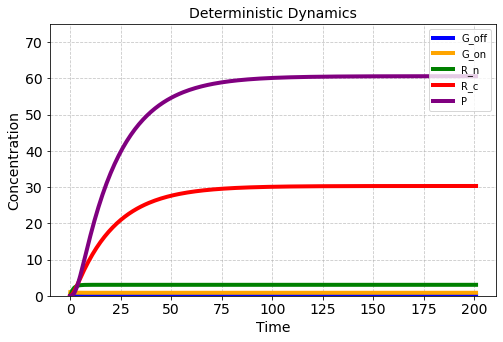

In [32]:
# Runnning the ODE model
time, concentrations_species = simulate_deterministic(parameter_values,
                                                      initial_conditions,
                                                      total_simulation_time,
                                                      drug_application_time,
                                                      inhibited_parameters)
plotting_deterministic(time,concentrations_species,species_colors,ylim_val=75)

In [ ]:
# Running SSA
trajectories_species, time  = simulate_stochastic(parameter_values,
                                                  initial_conditions,
                                                  number_of_trajectories,
                                                  total_simulation_time,
                                                  drug_application_time,
                                                  inhibited_parameters)
#plotting_stochastic(time, trajectories_species,species_colors,ylim_val=55)
#plotting_stochastic_dist_all_species(time, trajectories_species, species_colors, time_point=20)
plotting_combined(time, trajectories_species, species_colors,drug_application_time, time_point=60)

# Solving the model after drug application

In [ ]:
# Model Parameters
drug_application_time = 60
inhibited_parameters={'k_t': '0.1'}

In [ ]:
# Runnning the ODE model
time, concentrations_species = simulate_deterministic(parameter_values,
                                                      initial_conditions,
                                                      total_simulation_time,
                                                      drug_application_time,
                                                      inhibited_parameters)
plotting_deterministic(time,concentrations_species,species_colors,drug_application_time,ylim_val=80)

In [ ]:
# Running SSA
trajectories_species, time  = simulate_stochastic(parameter_values,
                                                  initial_conditions,
                                                  number_of_trajectories,
                                                  total_simulation_time,
                                                  drug_application_time,
                                                  inhibited_parameters)
plotting_stochastic(time, trajectories_species,species_colors,drug_application_time,ylim_val=80)



In [ ]:
plotting_stochastic_dist_all_species(time, trajectories_species, species_colors, time_point=40)
plotting_stochastic_dist_all_species(time, trajectories_species, species_colors, time_point=80)
#plotting_stochastic_dist_all_species(time, trajectories_species, species_colors, time_point=100)

In [ ]:
# Simulated data
T_MEASUREMENTS = np.array([5,10,20,40,60,80,100]).astype(int)
observation_data_P = np.zeros(T_MEASUREMENTS.shape[0])
observation_data_R_n = np.zeros(T_MEASUREMENTS.shape[0])
observation_data_P_variance = np.zeros(T_MEASUREMENTS.shape[0])
observation_data_R_n_variance = np.zeros(T_MEASUREMENTS.shape[0])
species_name = 'P'
for i,time_point in enumerate (T_MEASUREMENTS):
  observation_data_P[i] = np.mean(trajectories_species['P'][:, time_point]) # R_n_exp_mean
  observation_data_R_n[i] = np.mean(trajectories_species['R_n'][:, time_point]) # R_n_exp_mean
  observation_data_P_variance[i] = np.var(trajectories_species['P'][:, time_point]) # R_n_exp_variance
  observation_data_R_n_variance[i] = np.var(trajectories_species['R_n'][:, time_point]) # R_n_exp_variance
observation_data = [observation_data_P,observation_data_R_n]
observation_data_variance = [observation_data_P_variance,observation_data_R_n_variance]


In [ ]:
observation_data

In [ ]:
observation_data_variance

In [ ]:
#plotting_combined(time, trajectories_species, species_colors,drug_application_time, time_point=20)


In [ ]:
raise

# Parameter Estimation

In [ ]:
#@title metropolis hastings
def adaptive_metropolis(log_target_pdf,
               start,
               chain_len,
               cov_matrix,
               rng=np.random.default_rng()):
  pdim = len(start)

  samples = np.zeros((chain_len, pdim))
  log_target_pdfs = np.zeros((chain_len,))

  samples[0,:] = start[:]
  log_target_pdfs[0] = log_target_pdf(samples[0,:])

  nacc = 0

  pbar = tqdm(range(chain_len-1))
  for i in pbar:
      xpropose = rng.multivariate_normal(samples[i,:], cov_matrix)

      logpipropose = log_target_pdf(xpropose)

      logu = np.log(rng.uniform(0, 1))

      if logu <= logpipropose - log_target_pdfs[i]:
          # Accept
          samples[i+1, :] = xpropose[:]
          log_target_pdfs[i+1] = logpipropose
          nacc += 1
      else:
          # Reject
          samples[i+1, :] = samples[i, :]
          log_target_pdfs[i+1] = log_target_pdfs[i]

      if i > 1:
        cov_matrix = np.cov(samples[0:i + 1, :], None, rowvar=False) + 1.0e-6 * 2.4**2.0/ pdim * \
                            np.eye(pdim)

      pbar.set_postfix(acceptance_rate=nacc/(i+1))

  return samples, log_target_pdfs

In [ ]:
def adaptive_metropolis(log_target_pdf, start, chain_len, cov_matrix, rng=np.random.default_rng()):
    pdim = len(start)

    samples = np.zeros((chain_len, pdim))
    log_target_pdfs = np.zeros(chain_len)
    samples[0, :] = start
    log_target_pdfs[0] = log_target_pdf(samples[0, :])

    nacc = 0  # Number of accepted proposals
    cov_matrix_adjustment = 1.0e-6 * (2.4 ** 2.0) / pdim  # Adjustment factor for the covariance matrix
    update_freq = 50  # Frequency of covariance matrix updates

    pbar = tqdm(total=chain_len-1)
    for i in range(chain_len - 1):
        xpropose = rng.multivariate_normal(samples[i, :], cov_matrix)
        logpipropose = log_target_pdf(xpropose)
        logu = np.log(rng.uniform(0, 1))

        if logu <= logpipropose - log_target_pdfs[i]:
            samples[i + 1, :] = xpropose
            log_target_pdfs[i + 1] = logpipropose
            nacc += 1
        else:
            samples[i + 1, :] = samples[i, :]
            log_target_pdfs[i + 1] = log_target_pdfs[i]

        if (i + 1) % update_freq == 0 and i > 1:
            cov_matrix = np.cov(samples[:i + 1, :], rowvar=False) + cov_matrix_adjustment * np.eye(pdim)

        if (i + 1) % 100 == 0:  # Update progress bar every 100 iterations
            pbar.update(100)
            pbar.set_postfix(acceptance_rate=nacc / (i + 1))

    pbar.close()
    return samples, log_target_pdfs


In [ ]:
def Loglikelihood(  parameters,
                    observations ,
                    t_measurements):
    parameter_values = {
            'k_on': parameters[0],
            'k_off': parameters[1],
            'k_r': parameters[2],
            'k_t': parameters[3],
            'k_p': parameters[4],
            'gamma_rn': parameters[5],
            'gamma_rc': parameters[6],
            'gamma_p': parameters[7]
        }
    initial_conditions = {
        'G_off': 0,
        'G_on': 1,
        'R_n': 0,
        'R_c': 0,
        'P' : 0
    }
    total_simulation_time = 100
    drug_application_time = 50
    inhibited_parameters={'k_t': '0.1'}
    time, concentrations_species = simulate_deterministic(parameter_values,
                                                        initial_conditions,
                                                        total_simulation_time,
                                                        drug_application_time,
                                                        inhibited_parameters)
    y_R_n = concentrations_species['R_n'][t_measurements]
    y_R_c = concentrations_species['R_c'][t_measurements]
    y_P = concentrations_species['P'][t_measurements]
    SIGMA=1
    loglikelihood = 0.0
    for i in range(observations[0].shape[0]):
        #loglikelihood += np.sum(np.log(mrna_distributions[i][observations[i]]))
        #loglikelihood += np.sum(np.log(mrna_distributions[i][observations[i]]))
        loglikelihood +=  ( (np.sum(observations[0][i]) - y_P[i])**2/(2*SIGMA**2.0)  ) +   (  (np.sum(observations[1][i]) -y_R_n[i])**2/(2*SIGMA**2.0)   )
    return -loglikelihood

In [ ]:
BG_MU = np.array([-1.0, -1.0, -1.0, -1.0, -1.0,-1.0,-1.0,-1.0])
BG_SIGMA = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

def bg_prior_sample(n_sample: int, rng=np.random.default_rng()) -> np.ndarray:
    in_range = False
    while in_range == False:
      prior_sample = rng.normal(loc=BG_MU, scale=BG_SIGMA, size=(n_sample, BG_MU.shape[0]))
      if np.any(10.0**(prior_sample) < 0.0001) or np.any(10.0**(prior_sample) > 10):
          in_range= False
      else:
          in_range = True
    return prior_sample

def bg_logprior(parameter: np.ndarray):
    #return -2.0*np.sum((parameter - BG_MU)**2.0 ) #/(BG_SIGMA**2.0))
    return -1.0*np.sum((parameter - BG_MU)**2.0/(2*BG_SIGMA**2.0))

def bg_log_target(theta):
  transformed_theta = 10.0**(theta)
  if np.any(transformed_theta < 0.0001) or np.any(transformed_theta > 100):
    return -1e200
  else:
    return bg_logprior(theta) + Loglikelihood(transformed_theta, observations=observation_data, t_measurements=T_MEASUREMENTS)

In [ ]:
chain_start = bg_prior_sample(n_sample=1)[0]
print('inital guess:', 10.0**(chain_start))

In [ ]:
run_ms = False
if run_ms:
    bg_chain, bg_logpos = adaptive_metropolis(bg_log_target,
                                            start=chain_start,
                                            chain_len=1000000,
                                            cov_matrix=np.eye(BG_MU.shape[0]))
    np.save('bg_chain.npy', bg_chain)
    np.save('bg_logpos.npy', bg_logpos)
else:
    bg_chain = np.load('bg_chain.npy')
    bg_logpos = np.load('bg_logpos.npy')

In [ ]:
# save bg_chain, bg_logpos with numpy save

#np.save('bg_chain.npy', bg_chain)
#np.save('bg_logpos.npy', bg_logpos)

# load bg_chain, bg_logpos with numpy load
#bg_chain = np.load('bg_chain.npy')
#bg_logpos = np.load('bg_logpos.npy')

In [ ]:
fig, axs = plt.subplots(2, 8, figsize=(20, 4))  # Adjusted for a horizontal layout
fig.set_tight_layout(True)

# Setting titles for the top row for "MCMC Chain" and the bottom row for "Autocorrelation"
for i in range(8):
    if i == 3:
        axs[0, i].set_title("MH Chain", fontsize=20)
        axs[1, i].set_title("Autocorrelation", fontsize=20)
        
    # MCMC chain plot
    axs[0, i].plot(bg_chain[2000:, i], color='lightslategray', lw=2)
    axs[0, i].axhline(theta_true[i], color='orangered', lw=3)
    axs[0, i].set_ylabel(parameter_symbols[i])
    axs[1, i].set_ylabel(parameter_symbols[i])
    axs[0, i].set_xlabel('MH-steps')
    axs[1, i].set_xlabel('MH-steps')
    
    # Autocorrelation plot
    # Note: Adjust the autocorrelation calculation based on your version of emcee
    autocorr = emcee.autocorr.function_1d(bg_chain[2000:, i]) if hasattr(emcee.autocorr, 'function_1d') else np.correlate(bg_chain[2000:, i], bg_chain[2000:, i], mode='full')[len(bg_chain[2000:, i])-1:] / len(bg_chain[2000:, i])
    axs[1, i].plot(autocorr, color='lightslategray', lw=3)

fig.savefig(folder_outputs+"mcmc_trajectories_horizontal.png", dpi=400, bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(15, 6))  # Adjusted to a 2x4 layout
fig.set_tight_layout(True)

# Loop through the parameter indices and plot
for i in range(8):
    row = i // 4  # Calculate row index
    col = i % 4  # Calculate column index
    # MCMC chain plot
    axs[row, col].plot(bg_chain[2000:, i], color='lightslategray', lw=2)
    axs[row, col].axhline(theta_true[i], color='orangered', lw=3)
    axs[row, col].set_ylabel(parameter_symbols[i])
    axs[row, col].set_xlabel('MH-steps')
# adding title for all plots
fig.suptitle("Metropolis-Hastings Chains", fontsize=20)

# Adjust the layout
fig.tight_layout()
fig.savefig(folder_outputs+"mcmc_trajectories_parameters.png", dpi=400, bbox_inches="tight")
plt.show()

In [ ]:

fig, axs = plt.subplots(2, 4, figsize=(15, 6))  # Adjusted to a 2x4 layout
fig.set_tight_layout(True)

# Loop through the parameter indices and create histograms
for i in range(8):
    row = i // 4  # Calculate row index
    col = i % 4  # Calculate column index
    
    data = bg_chain[2000:, i]  # Extracting the burn-in adjusted chain for the parameter
    mean = np.mean(data)  # Calculate the mean of the parameter's chain
    ci_lower, ci_upper = np.percentile(data, [5, 95])  # Calculate the 90% CI
    
    # Histogram plot
    axs[row, col].hist(data, bins=30, color='lightslategray', alpha=0.7)
    axs[row, col].axvline(mean, color='orangered', lw=4, label='Estimate')
    axs[row, col].axvline(ci_lower, color='blue', linestyle='--', lw=2, label='90% CI')
    axs[row, col].axvline(ci_upper, color='blue', linestyle='--', lw=2)
    axs[row, col].axvline(theta_true[i], color='green', lw=4, label='True', linestyle='--')  # Marking the true parameter value
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].set_xlabel(parameter_symbols[i])
    axs[row, col].legend()

# Adding a title for all plots
fig.suptitle("Parameter Uncertainty", fontsize=20)

# Adjust the layout
fig.tight_layout()

# Save the figure
fig.savefig(folder_outputs+"mcmc_parameter_distributions_with_true.png", dpi=400, bbox_inches="tight")
plt.show()


In [ ]:
sns.set(style="white")  # Set Seaborn style
chain_trunc = bg_chain[2000:, :]  # Remove burn-in samples
fig, axs = plt.subplots(8, 8, figsize=(15, 15))
fig.tight_layout(pad=2.0)

for i in range(8):
    for j in range(i):
        axs[i, j].hexbin(chain_trunc[:, j], chain_trunc[:, i], gridsize=15, cmap='plasma', mincnt=1)
        axs[i, j].tick_params(axis='both', which='major', labelsize=8)
        if j == 0:
            axs[i, j].set_ylabel(parameter_symbols[i], fontsize=10)
        if i == 7:  # This ensures the x labels appear at the bottom row
            axs[i, j].set_xlabel(parameter_symbols[j], fontsize=10)
    for j in range(i + 1, 8):
        axs[i, j].axis('off')
        
    # Plot histogram
    n, bins, patches = axs[i, i].hist(chain_trunc[:, i], color='lightslategray', bins=10)
    axs[i, i].axvline(theta_true[i], color="orangered", lw=4)
    axs[i, i].tick_params(axis='both', which='major', labelsize=8)
    
    # Use scientific notation for y-axis
    axs[i, i].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    axs[i, i].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.show()

fig.savefig(folder_outputs+"mcmc_distributions.png", dpi=400, bbox_inches="tight")

In [ ]:
# plot the ODE model with the best fit parameters
best_fit = np.mean(bg_chain[2000:], axis=0)
print('best fit:', 10.0**(best_fit))
parameter_values = {
            'k_on': 10.0**(best_fit[0]),
            'k_off': 10.0**(best_fit[1]),
            'k_r': 10.0**(best_fit[2]),
            'k_t': 10.0**(best_fit[3]),
            'k_p': 10.0**(best_fit[4]),
            'gamma_rn': 10.0**(best_fit[5]),
            'gamma_rc': 10.0**(best_fit[6]),
            'gamma_p': 10.0**(best_fit[7])
        }
initial_conditions = {
    'G_off': 0,
    'G_on': 1,
    'R_n': 0,
    'R_c': 0,
    'P' : 0
}
total_simulation_time = 100
drug_application_time = 50
inhibited_parameters={'k_t': '0.1'}
time, concentrations_species = simulate_deterministic(parameter_values,
                                                      initial_conditions,
                                                      total_simulation_time,
                                                      drug_application_time,
                                                      inhibited_parameters)

# solving the model with the true parameters
true_parameter_values = {
            'k_on': 0.5,
            'k_off': 0.1,
            'k_r': 5,
            'k_t': 4,
            'k_p': 2,
            'gamma_rn': 0.1,
            'gamma_rc': 0.5,
            'gamma_p': 0.5
}
time, concentrations_species_true = simulate_deterministic(true_parameter_values,
                                                      initial_conditions,
                                                      total_simulation_time,
                                                      drug_application_time,
                                                      inhibited_parameters)

#plotting_deterministic(time,concentrations_species,species_colors,drug_application_time,ylim_val=55)



# Plotting the ODE model and the experimental data only for variables P and R_n
plt.figure(figsize=(8, 5))
plt.plot(T_MEASUREMENTS, observation_data_P, 'o', color='purple', label=' Data (P)', markersize=8)
plt.plot(T_MEASUREMENTS, observation_data_R_n, 'o', color='green', label=' Data (R_n)', markersize=8)
plt.plot(time, concentrations_species['P'], color='purple', label='Model Fit (P)', lw=4)
plt.plot(time, concentrations_species['R_n'], color='green', label='Model Fit (R_n)', lw=4)
# plotting for concentrations_species_true
plt.plot(time, concentrations_species_true['P'], color='purple', label='True Model (P)', lw=2, linestyle='--')
plt.plot(time, concentrations_species_true['R_n'], color='green', label='True Model (R_n)', lw=2, linestyle='--')

# plotting the standard deviation for T_MEASUREMENTS
#plt.fill_between(T_MEASUREMENTS, observation_data_P - np.sqrt(observation_data_P_variance), observation_data_P + np.sqrt(observation_data_P_variance), color='blue', alpha=0.1)
#plt.fill_between(T_MEASUREMENTS, observation_data_R_n - np.sqrt(observation_data_R_n_variance), observation_data_R_n + np.sqrt(observation_data_R_n_variance), color='green', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('ODE Model vs Data')
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 55)
# save the figure

plt.savefig(folder_outputs+'model_fit.png', dpi=400, bbox_inches="tight")
plt.show()

